# <p style="background-color:#202124;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:40px 40px;display:block;">Brain Tumor Detection</p>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchsummary
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score,classification_report

from tqdm import tqdm_notebook as tqdm
import time
import warnings
warnings.simplefilter("ignore")

# <p style="background-color:#202124;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:40px 40px;display:block;">HyperParamaters</p>

In [ ]:
Training = '/content/drive/MyDrive/Brain tumour data/Brain-Tumor-Classification-DataSet-master/Brain-Tumor-Classification-DataSet-master/Training/'
Testing = '/content/drive/MyDrive/Brain tumour data/Brain-Tumor-Classification-DataSet-master/Brain-Tumor-Classification-DataSet-master/Testing/'

IMAGE_SIZE=(150,150)
batch_size=64
learning_rate = 0.00008
epochs=20
num_classes=4

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)

cpu


In [ ]:
def images_transforms(phase):
    if phase == 'training':
        data_transformation = transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
#             transforms.RandomEqualize(10),
            transforms.RandomRotation(degrees=(-25,20)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    else:
        data_transformation=transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])


    return data_transformation

In [ ]:
trainset=datasets.ImageFolder(Training,transform=images_transforms('training'))
testset=datasets.ImageFolder(Testing,transform=images_transforms('test'))
testset, valset = torch.utils.data.random_split(testset, [150, 244])


In [ ]:
train_loader = DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=2)
test_loader = DataLoader(testset,batch_size=batch_size,shuffle=True,num_workers=2)
val_loader = DataLoader(valset,batch_size=batch_size,shuffle=True,num_workers=2)

# <p style="background-color:#202124;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:40px 40px;display:block;">Model Creation and Initialization</p>

In [ ]:
model=torchvision.models.mobilenet_v3_large(pretrained=True)
num_features=model.classifier[0].in_features
model.classifier=nn.Sequential(
    nn.Linear(in_features=num_features, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=num_classes, bias=True)
  )

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 64.5MB/s]


In [ ]:
model=model.to(device)
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(),lr=learning_rate)

# <p style="background-color:#202124;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:40px 40px;display:block;">Model Training</p>

In [ ]:
def test(model,testloader):
    with torch.no_grad():
        n_correct=0
        n_samples=0
        y_pred=[]
        y_actual=[]
        for i,(images,labels) in enumerate(testloader):
            images=images.to(device)
            labels=labels.to(device)

            outputs=model(images)

            y_actual+=list(np.array(labels.detach().to('cpu')).flatten())
        # value ,index
            _,predictes=torch.max(outputs,1)
            y_pred+=list(np.array(predictes.detach().to('cpu')).flatten())
        # number of samples in current batch
            n_samples+=labels.shape[0]

            n_correct+= (predictes==labels).sum().item()

        y_actual=np.array(y_actual).flatten()
        y_pred=np.array(y_pred).flatten()
        print(np.unique(y_pred))
        acc = classification_report(y_actual,y_pred,target_names=trainset.classes)
        print(f"{acc}")

def train(model,train_loader,criterion,optimizer,val_loader,epochs=25):
    train_losses = []
    val_losses = []
    train_auc = []
    val_auc = []
    train_auc_epoch = []
    val_auc_epoch = []
    val_acc = 0.0
    train_acc=0.0
    min_loss = np.Inf

    since = time.time()
    y_actual=[]
    y_pred=[]
    for e in range(epochs):
        y_actual=[]
        y_pred=[]
        train_loss = 0.0
        val_loss = 0.0

        # Train the model
        model.train()
        for i, (images, labels) in enumerate(tqdm(train_loader, total=int(len(train_loader)))):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and accuracy
            train_loss += loss.item()

            _,predictes=torch.max(outputs,1)
            y_actual += list(labels.data.cpu().numpy().flatten())
            y_pred += list(predictes.detach().cpu().numpy().flatten())
        train_auc.append(accuracy_score(y_actual, y_pred))

        # Evaluate the model
        model.eval()
        for i, (images, labels) in enumerate(tqdm(val_loader, total=int(len(val_loader)))):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Loss and accuracy
            val_loss += loss.item()
            _,predictes=torch.max(outputs,1)
            y_actual += list(labels.data.cpu().numpy().flatten())
            y_pred += list(predictes.detach().cpu().numpy().flatten())

        val_auc.append(accuracy_score(y_actual, y_pred))

        # Average losses and accuracies
        train_loss = train_loss/len(train_loader)
        val_loss = val_loss/len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        training_auc = train_auc[-1]
        validation_auc = val_auc[-1]
        train_auc_epoch.append(training_auc)
        val_auc_epoch.append(validation_auc)

        # Updating best validation accuracy
        if val_acc < validation_auc:
            val_acc = validation_auc

        # Updating best training accuracy
        if train_acc < training_auc:
            train_acc = training_auc

        # Saving best model
        if min_loss >= val_loss:
            torch.save(model.state_dict(), 'best_model.pt')
            min_loss = val_loss

        print('EPOCH {}/{} Train loss: {:.6f},Validation loss: {:.6f}, Train AUC: {:.4f}  Validation AUC: {:.4f}\n  '.format(e+1, epochs,train_loss,val_loss, training_auc,validation_auc))
        print('-' * 10)
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation accuracy: {:4f}'.format(val_acc))
    print('Best training accuracy: {:4f}'.format(train_acc))
    return train_losses,val_losses,train_auc ,val_auc,train_auc_epoch,val_auc_epoch

In [ ]:
train_losses,val_losses,train_auc ,val_auc,train_auc_epoch,val_auc_epoch=train(model,train_loader,criterion,optimizer,val_loader,epochs)

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 1/20 Train loss: 0.977386,Validation loss: 1.165209, Train AUC: 0.6310  Validation AUC: 0.6169
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 2/20 Train loss: 0.477649,Validation loss: 1.130453, Train AUC: 0.8216  Validation AUC: 0.7951
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 3/20 Train loss: 0.332922,Validation loss: 1.105925, Train AUC: 0.8728  Validation AUC: 0.8459
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 4/20 Train loss: 0.257717,Validation loss: 1.204509, Train AUC: 0.9056  Validation AUC: 0.8783
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 5/20 Train loss: 0.216522,Validation loss: 1.258415, Train AUC: 0.9192  Validation AUC: 0.8905
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 6/20 Train loss: 0.186272,Validation loss: 1.500519, Train AUC: 0.9334  Validation AUC: 0.9008
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 7/20 Train loss: 0.159111,Validation loss: 1.601084, Train AUC: 0.9411  Validation AUC: 0.9075
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 8/20 Train loss: 0.132182,Validation loss: 1.518145, Train AUC: 0.9533  Validation AUC: 0.9200
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 9/20 Train loss: 0.118620,Validation loss: 1.739356, Train AUC: 0.9540  Validation AUC: 0.9207
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 10/20 Train loss: 0.108501,Validation loss: 1.717056, Train AUC: 0.9589  Validation AUC: 0.9290
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 11/20 Train loss: 0.095408,Validation loss: 1.691719, Train AUC: 0.9676  Validation AUC: 0.9377
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 12/20 Train loss: 0.088550,Validation loss: 1.736421, Train AUC: 0.9690  Validation AUC: 0.9374
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 13/20 Train loss: 0.066405,Validation loss: 1.816643, Train AUC: 0.9784  Validation AUC: 0.9483
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 14/20 Train loss: 0.065821,Validation loss: 1.746477, Train AUC: 0.9767  Validation AUC: 0.9477
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 15/20 Train loss: 0.054788,Validation loss: 1.578390, Train AUC: 0.9815  Validation AUC: 0.9547
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 16/20 Train loss: 0.060974,Validation loss: 1.468371, Train AUC: 0.9801  Validation AUC: 0.9586
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 17/20 Train loss: 0.047646,Validation loss: 1.452085, Train AUC: 0.9861  Validation AUC: 0.9669
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 18/20 Train loss: 0.041917,Validation loss: 1.504330, Train AUC: 0.9861  Validation AUC: 0.9682
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 19/20 Train loss: 0.034356,Validation loss: 1.779310, Train AUC: 0.9899  Validation AUC: 0.9685
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 20/20 Train loss: 0.039885,Validation loss: 2.108079, Train AUC: 0.9854  Validation AUC: 0.9640
  
----------
Training completed in 106m 42s
Best validation accuracy: 0.968529
Best training accuracy: 0.989895


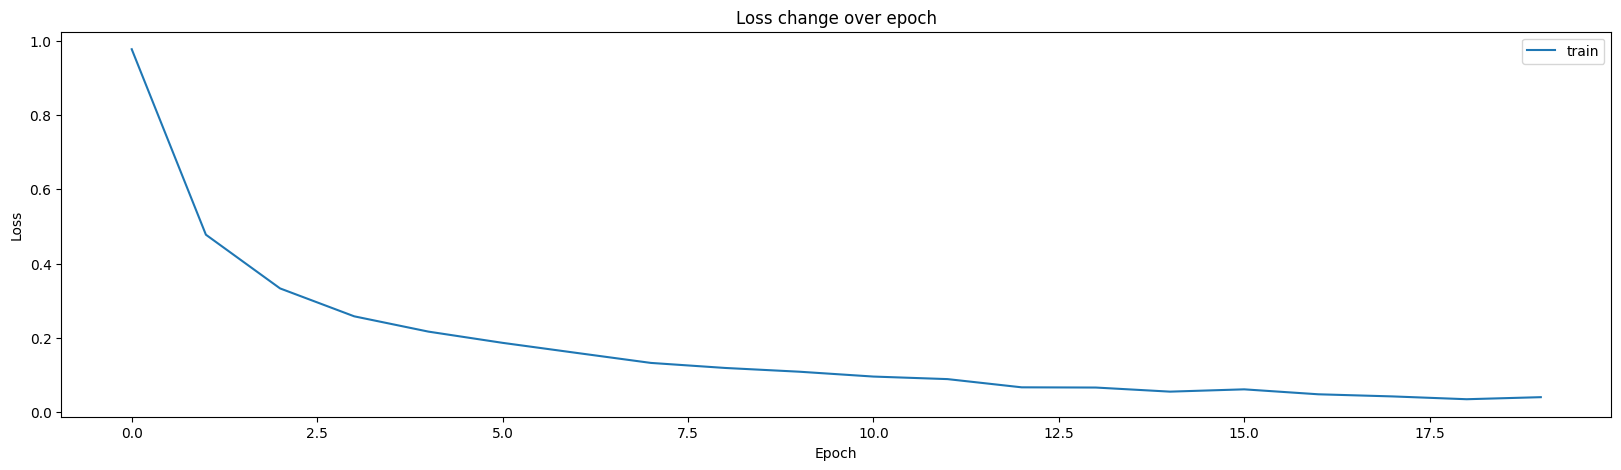

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(train_losses, label="train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss change over epoch")
plt.legend()

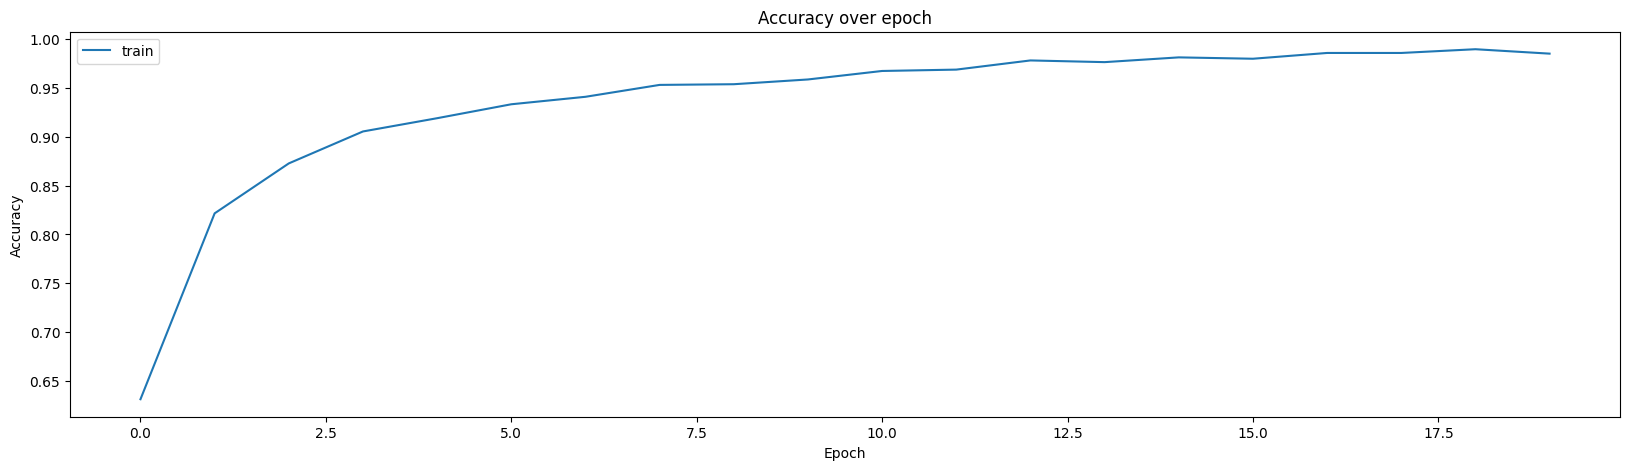

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(train_auc_epoch,label="train")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epoch")
plt.legend()